# Lab #2
### Cindy Chen

__The data set I am using for this lab is 2020 HMDA US individual mortgage applications where each row is a unique application. It incorporates 99 variables, documenting demographic and financial information about the applicant, mortgage details, as well as approval/denial outcomes. This data set interests me due to recent discourse around redlining and racial discrimination in mortgage approvals even though the process is largely "automated" via algorithms.__

In [260]:
#load all the packages I need for this lab
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as mpl
import os
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [261]:
#my dataset is 9 GB so I am only brgining in 8,000 rows... otherwise I don't have enough RAM
os.chdir("~/2020_lar/")
mortgage = pd.read_csv("2020_lar.txt", sep = "|", header = 0, nrows=8000)

#preview of the first 10 rows of the data set
mortgage.head(10)

,activity_year,lei,derived_msa_md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,...,denial_reason_2,denial_reason_3,denial_reason_4,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
0,2020,549300HTRLFU2IIL4380,12940,LA,22037.0,2.203795e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,3.0,NaN,NaN,7086,53.82,73800,81.0,1589,2010,28
1,2020,549300HTRLFU2IIL4380,99999,TX,48467.0,4.846795e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,7182,11.04,59100,120.0,2180,3048,29
2,2020,549300HTRLFU2IIL4380,99999,TX,48337.0,4.833795e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,4654,12.01,59100,114.0,1753,2709,32
3,2020,549300HTRLFU2IIL4380,99999,TX,48379.0,4.837995e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,6083,9.58,59100,113.0,2076,2995,23
4,2020,549300HTRLFU2IIL4380,26420,TX,48291.0,4.829170e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,5394,17.95,80000,89.0,1798,2627,25
5,2020,549300HTRLFU2IIL4380,99999,TX,48249.0,4.824995e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Hispanic or Latino,...,3.0,NaN,NaN,7209,79.11,59100,128.0,1589,2393,44
6,2020,549300HTRLFU2IIL4380,99999,TX,48363.0,4.836300e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,2897,16.26,59100,117.0,857,2832,34
7,2020,549300HTRLFU2IIL4380,99999,OK,40001.0,4.000138e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,4584,59.79,57500,88.0,1351,1945,34
8,2020,549300HTRLFU2IIL4380,99999,LA,22027.0,2.202795e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,3.0,NaN,NaN,2741,57.57,50400,94.0,599,1334,49
9,2020,549300HTRLFU2IIL4380,26420,TX,48201.0,4.820133e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Hispanic or Latino,...,3.0,NaN,NaN,11288,92.36,80000,92.0,2662,3192,11


__1. Recode 1 *sort of* continuous variable into categories.  Tell me what you did and explain the variable(s).__

The continuous variable I have chosen is the interest rate on the proposed mortgage, listed under the variable "interest_rate". To create the categories, I converted the column from an object to numeric data type so that I could see descriptive statistics about my data.  This guides the bin widths and the reasonable range that I set for my categories.  Since my interest rate range spanned 2.0 to 10.0, I decided to create three bins labelled "1", "2", and "3".  I decided to create my first bin of '1' with a threshold just below the mean interest rate, because my descriptive statistics suggested that interest rates are skewed to the right.  Since I know there are NaN values in my data, I also made sure to check that the NaNs are preserved in my new column called "interest_rate_range".

In observing the value counts and descriptive statsistics of the 'interest_rate_range' column, I can see that the majority (32.1%) of sample mortgages have interest rates that belong in my interest_rate_range of '1' (and are at least or below 3.0%), which are the lowest and thus most favorable mortgage rates.

In [262]:
#investigate the data type of my column in case I need to change it
mortgage['interest_rate'].dtype

#confirm the number of "na" entries I expect in my data set
len(mortgage[mortgage['interest_rate'].isna() == True])

#convert interest_rate column from object to numeric
mortgage['interest_rate'] = pd.to_numeric(mortgage['interest_rate'], errors = 'coerce')

#find the minimum and maximum interest rates so that I can set appropriate bins when I create categories
print(mortgage['interest_rate'].max())
print(mortgage['interest_rate'].min())
print(mortgage['interest_rate'].describe())

10.0
2.0
count    5144.000000
mean        3.528931
std         0.955839
min         2.000000
25%         2.990000
50%         3.375000
75%         3.750000
max        10.000000
Name: interest_rate, dtype: float64


Text(0.5, 0, 'interest rate')

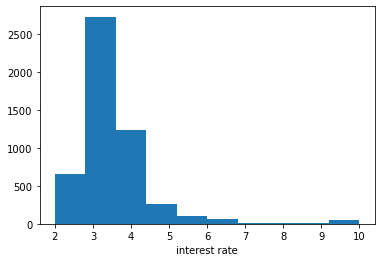

In [263]:
#visualization of right skew
mpl.hist(mortgage['interest_rate'])
mpl.xlabel('interest rate')

In [264]:
#set up the conditions for values in the interest_rate column where I have data (this doesn't include NaNs)
conditions = [
    (mortgage['interest_rate'] <= 3),
    (mortgage['interest_rate'] <= 7),
    (mortgage['interest_rate'] <= 10)]

#create the bins
equivalent_levels = [1, 2, 3]

#create a new column
mortgage['interest_rate_range'] = np.select(conditions, equivalent_levels, default = np.nan) 

#run the first 10 rows of these columns to make sure that entries appear as we expect
mortgage[['interest_rate','interest_rate_range']].head(10)

,interest_rate,interest_rate_range
0,NaN,NaN
1,NaN,NaN
2,9.47,3.0
3,9.47,3.0
4,NaN,NaN
5,NaN,NaN
6,9.47,3.0
7,NaN,NaN
8,NaN,NaN
9,NaN,NaN


In [265]:
mortgage.interest_rate_range.describe()

count    5144.000000
mean        1.693624
std         0.492438
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         3.000000
Name: interest_rate_range, dtype: float64

In [266]:
mortgage.interest_rate_range.value_counts()

2.0    3414
1.0    1653
3.0      77
Name: interest_rate_range, dtype: int64

In [267]:
#out of curiosity, I want to know the proportion of mortgages (where an interest rate is available)
#are considered '1' in my range
print("Proportion under Level 1:",
      np.round(len(mortgage[mortgage['interest_rate_range'] == 1])/
               len(mortgage.dropna(subset = ['interest_rate_range'])), decimals = 3)
                                                              * 100, "%")

Proportion under Level 1: 32.1 %


__2. Recode 1 another variable and attach value labels.  Tell me what you did and explain the variable(s).__

The second variable I will recode by attaching value labels is 'action_taken'.  This variable denotes whether a mortgage was approved or not approved (which includes denials and withdrawn applications).  In terms of my methodology, I recorded any 'action_taken' value labelled as '1' to be "approved" and any other value to be "not approved", as described in the HMDA data schema.  Since there are eight (8) possible values under 'action_taken', this recode is particularly helpful in my analysis because it elegantly organizes the final outcome of the mortgage application into 'approved' or not.

After recoding, I can see that the majority (66.7%) of applications in my sample of 8000 mortgage applications were approved.

In [268]:
#recode action taken into a binary label
conditions = [
    (mortgage['action_taken'] == 1),
    (mortgage['action_taken'] > 1)]

#create the labels
labels = ["approved", "not approved"]

#create a new column
mortgage['approved'] = np.select(conditions, labels, default = np.nan) 

#run the first 10 rows of these columns to make sure that entries appear as we expect
mortgage[['action_taken','approved']].head(10)

,action_taken,approved
0,3,not approved
1,3,not approved
2,1,approved
3,1,approved
4,3,not approved
5,3,not approved
6,1,approved
7,3,not approved
8,3,not approved
9,3,not approved


In [269]:
mortgage.approved.value_counts()

approved        5334
not approved    2666
Name: approved, dtype: int64

In [270]:
print("approval rate: ",
      round(len(mortgage[mortgage['approved'] == 'approved']) /
            len(mortgage['approved']), 3) * 100, "%")

approval rate:  66.7 %


(array([2666.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        5334.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

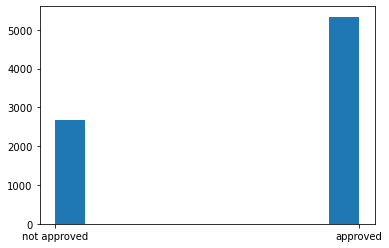

In [282]:
mpl.hist(mortgage['approved'])

__3. Use one (or both) of your recoded variables to do a cross-tabulation (as you had done last week, with prop.table, doBy, or ddply). Explain your results.__

I will now create a cross-tabulation between income and interest rate.   I chose to incorporate only 'interest_rate' (which I previously created) in my cross-tabulation and exclude the 'action_taken' recode, because I am very interested in seeing the relationship between an applicant's income and the interest rate of their proposed mortgage.  However, it requires me to recode 'income'. In terms of my methodology, I first made sure that income is a continuous numeric variable, which means that I can recode it into ranges. Afterwards, I found descriptive statistics to help met set the bins, and then I created the new variable, which I call "income_levels", which incorporates 5 value labels.

Through this exercise, I notice that income can range from -\\$4,000 to \\$8.8 million, and the average income is \\$107,551.  These numbers make sense intuitively as $110,000 seems like a realistic mean income for a dual-income household.

Through my cross-tabulation, I can observe several fascinating insights.

* Lower income brackets have a greater share of mortgages with the most favorable interest rates.  We can see this is in the first row of the cross-tab where 32.33% of income_levels = 2 applicants (who make between 0 and \\$40K) enjoyed interest rates below 3.0%; the share of applicants enjoying the lowest interest rate range steady declines as the income level increases.  This might be explained by the fact that those with lower incomes might be more conservative / less risky with the mortgage amount that they request to borrow, so banks can extend them more favorable terms.  Another explanation may be that there are government programs in place to grant lower-income homebuyers better interest rates as to promote home ownership.


* Nobody in income_level = 5 (people who made above $500K) received interest rates above 7.0% (as stipulated by the range denoted by interest_rate_range = 3).


* Interestingly, a larger portion of those in income_levels = 4.0 (making between \\$110,000 and \\$500,000 dollars in annual income) received interest_rates in the third tier (the least favorable interest rates) compared to those in lower income levels.  We can see this as only 0.64% of income_levels = 2 and 1.40% of income_levels = 3 received interest rates in the highest range, while 1.92% of income_levels = 4 were in the same ordeal.  If the relationship between income levels and interest rates holds (where higher income applicants enjoy better interest rates), then this would be an anomaly.  When I ran an additional cross-tab on the applicant count, I can see that the number of applicants in the third and fourth income tiers are quite large, so the distribution of applications is not drastically skewed due to a few outliers.  This suggests that people in the fourth income tier are more likely to live beyond their means; their desire to buy a larger home and willingness to take on a bigger (riskier) mortgage leads to less favorable interest rates than their income bracket would typically ensure.  Likewise, data quality issues in the form of missing interest rates is not a convincing explanation for why we notice a jump in high interest rates among income_levels = 4, because income levels 3 and 4 are missing data at the same proportion of 33% (as illustrated below).

In [271]:
#evaluate the data type of my column; confirm that it's 'float64'
mortgage['income'].dtype

dtype('float64')

In [272]:
#I assume that the mortgages are in the 1000's even though I can't find this detail in the schema.  However, this
#would make sense given the mean income.
mortgage['income'].describe() #min income of -$4,000, max income of $8,800,000, and mean income of $107,551

count    7738.000000
mean      107.550788
std       141.720717
min        -4.000000
25%        55.000000
50%        84.000000
75%       130.000000
max      8800.000000
Name: income, dtype: float64

In [273]:
conditions2 = [(mortgage['income'] < 0),
             (mortgage['income'] <= 40),
             (mortgage['income'] <= 110),
             (mortgage['income'] <= 500),
             (mortgage['income'] > 500)]

my_levels2 = [1, 2, 3, 4, 5]

#create the new column
mortgage['income_levels'] = np.select(conditions2, my_levels2, default = np.nan)

#view my new column to make sure it's showing up as expected
mortgage[['income', 'income_levels']].head(10)

,income,income_levels
0,33.0,2.0
1,108.0,3.0
2,68.0,3.0
3,93.0,3.0
4,20.0,2.0
5,11.0,2.0
6,125.0,4.0
7,52.0,3.0
8,45.0,3.0
9,59.0,3.0


In [274]:
interest_vs_income = pd.crosstab(mortgage.interest_rate_range, mortgage.income_levels)
np.round(interest_vs_income.astype('float').div(interest_vs_income.sum(axis=0), axis=1) * 100, decimals = 2)

income_levels,2.0,3.0,4.0,5.0
interest_rate_range,,,,
1.0,32.33,31.91,30.74,28.57
2.0,67.02,66.69,67.34,71.43
3.0,0.64,1.40,1.92,0.00


In [275]:
#I want to run a cross tab on the count so I can get context on why those in income_level = 4 observe a higher
#rate of applicants receiving the least favorable interest rates.
pd.crosstab(mortgage.interest_rate_range, mortgage.income_levels)

income_levels,2.0,3.0,4.0,5.0
interest_rate_range,,,,
1.0,151,912,529,4
2.0,313,1906,1159,10
3.0,3,40,33,0


In [276]:
#Among the data where I am missing interest rates, I wanted to see the distribution of it to see if that 
#might explain why the income_level of 4 has a bigger proportion of applicants with the highest interest rates
#compared to those in income_level = 3.
missing_data = mortgage[mortgage['interest_rate_range'].isna() == True]
missing_data = missing_data[['interest_rate_range', 'income_levels']]
missing_data.income_levels.value_counts()

3.0    1397
4.0     853
2.0     403
5.0      24
1.0       1
Name: income_levels, dtype: int64

In [277]:
print("income_levels = 2 missing data proportion: ",
      np.round(len(missing_data[missing_data['income_levels'] == 2])/len(mortgage[mortgage['income_levels'] == 2]), 2)
      * 100, "%")

print("income_levels = 3 missing data proportion: ",
      np.round(len(missing_data[missing_data['income_levels'] == 3])/len(mortgage[mortgage['income_levels'] == 3]), 2)
      * 100, "%")

print("income_levels = 4 missing data proportion: ",
      np.round(len(missing_data[missing_data['income_levels'] == 4])/len(mortgage[mortgage['income_levels'] == 4]), 2)
      * 100, "%")

income_levels = 2 missing data proportion:  46.0 %
income_levels = 3 missing data proportion:  33.0 %
income_levels = 4 missing data proportion:  33.0 %


__4. Run a linear regression with 1 independent and 1 dependent variable.  Make all of the recodes necessary to make the model as easy to interpret as possible.  And explain your results.__

I chose to run a linear regression on income and loan amount.  My hypothesis is that an applicant's income is correlated with the loan amount that they request.  My null hypothesis would be that there is no relationship between an applicant's income and the loan amount they request.

__Conclusion:__ I can reject my null hypothesis.  My P-value is rounded to 0.000, which is below a threshold of 0.05 (and therefore leads me to reject the null), but my R-squared is pretty low (0.078) so this model cannot explain a majority of the randomness.  However, my coefficient of 277.83 seems realistic, as it suggests that for every thousand dollars of income, an applicant typically requests an additional \\$277 to their mortgage.  This seems plausible since the intercept starts at \\$194,400.

In [278]:
lm = smf.ols(formula = 'loan_amount ~ income', data = mortgage).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:            loan_amount   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     658.1
Date:                Thu, 21 Oct 2021   Prob (F-statistic):          2.26e-139
Time:                        20:19:17   Log-Likelihood:            -1.0239e+05
No. Observations:                7738   AIC:                         2.048e+05
Df Residuals:                    7736   BIC:                         2.048e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.944e+05   1926.645    100.890      0.0


__5. Plot two variables, either as a scatter plot or boxplot.  Explain your results.__

I decided to create a boxplot showing the applicant age group (already categorized in the data set) and the property value (which I will have to convert into a numeric variable).  I am very curious about the mortgage sizes that various age groups qualified for.  My hypothesis is that younger age groups and the oldest age groups request mortgages for lower property values, since young people want to buy a starter home and retirees want to downsize.

* In analyzing the boxplot, I can see that the narrowest range in mortgage amounts and the lowest median mortgage amount occurs in the "<25" age group. This makes sense as their credit history is still quite limited and they likely don't have high incomes to qualify for large mortgages.


* Meanwhile, there are lots of outliers in mortgage amounts among the 45-54 age group based on the number of dots outside the bars.  However, they are quite close together so there aren't any extreme outliers in loan amounts.


* My hypothesis around downsizing might not hold, because this trend is not very pronounced in the data.  In the age groups "65-74" and ">74", the median property value is not significantly lower than the median for younger age groups.  While the upper quartiles and upper whiskers are narrower than younger age groups, the lower quartiles and lower whiskers remain consistent with younger age groups, suggesting that retirees aren't downsizing as aggressively as I hypothesized.  We also see some major outliers in the >74 age where people with accumulated wealth are buying multi-million dollar homes that are much more expensive than what others are purchasing.

In [279]:
#confirm that the variables I plan to use in my scatterplot are in a data type that can be plotted
print("property value dtype: ", mortgage['property_value'].dtype)
print("applicant age dtype: ", mortgage['applicant_age'].dtype)

#since property value is composed of numbers that haven't been set to numeric, I will coerce the data type
mortgage['property_value'] = pd.to_numeric(mortgage['property_value'], errors = 'coerce')
print("new property value: ", mortgage['property_value'].dtype)

property value dtype:  object
applicant age dtype:  object
new property value:  float64


<AxesSubplot:xlabel='applicant_age', ylabel='property_value'>

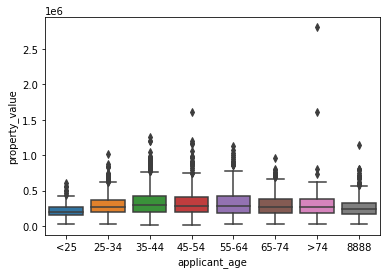

In [280]:
sb.boxplot(x = 'applicant_age', y = 'property_value', data = mortgage,
          order = ['<25', '25-34', '35-44', '45-54', '55-64', '65-74', '>74', '8888'])

[(0.0, 1500000.0)]

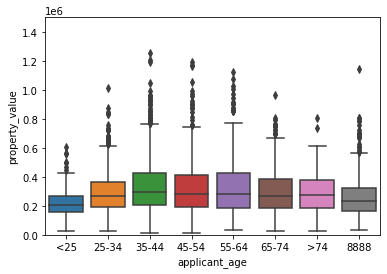

In [281]:
#I set a limit on my dependent variable range so that it ignores major outliers and it's easier to see
#differences in each age group's boxes
sb.boxplot(x = 'applicant_age', y = 'property_value', data = mortgage,
          order = ['<25', '25-34', '35-44', '45-54', '55-64', '65-74', '>74', '8888']).set(ylim = (0, 1500000))

__6. Tell me two theories/ideas you might want to test in this course. Do you have a dataset for these ideas/theories already? Do you have it in R-readable format already? What is your main independent variable? What is your main dependent variable?__

I would be interested in using this same data set, the HMDA (Home Mortgage Disclosure Act) data set on mortgage applications and approvals.  However, I am concerned about how I can work with this set given its 9 GB size, despite the fact that it is in a readable .txt format.  For instance, do I have to access a virtual computer or use a computer in a lab on campus to process it?

I'm interested in seeing whether the pandemic-induced real estate frenzy (in terms of heightened demand for single-family homes) shows any patterns that suggest redlining or racial bias in who gets approved for mortgages in that area.  My hypothesis is that census tracts that had much higher than average housing demand in 2020 demonstrated greater racial discrimination in who was denied/approved for a mortgage as to 'curate' certain neighborhood demographics.  My main independent variables would be location (in the form of 'county_code' or 'census_tract'), and 'derived_race'.  Meanwhile, my main dependent variable would be the column labelled "Action Taken" that stipulates the outcome of the mortgage application.

Meanwhile, my second theory is that young people (under 25) employ different strategies by race to gain mortgage approval.  For instance, successful applicants who are White might be more likely to involve a cosigner who is their parent, while successful applicants who are Black might be more likely to qualify for mortgages based on lower debt-to-income ratios without the help of a cosigner, due to racial disparities in intergenerational wealth.  My primary independent variables would be 'debt_to_income_ratio', 'derived_race', and 'co_applicant_credit_score_type' (the best proxy for the existence of a co-signer that we have).  My dependent variable would be 'loan_amount'.